# Transfer Learning

## What is transfer learning?

Transfer learning allows us to take the patterns (also called weights) another model has learned from another problem and use them for our own problem.

For example, we can take the patterns a computer vision model has learned from datasets such as <a href='https://www.image-net.org/'>ImageNet</a> (millions of images of different objects) and use them to power our FoodVision Mini model.

Or we could take the patterns from a language model (a model that's been through large amounts of text to learn a representation of language) and use them as the basis of a model to classify different text samples.

The premise remains: find a well-performing existing model and apply it to your own problem.

Example of transfer learning being applied to computer vision and natural language processing (NLP). In the case of computer vision, a computer vision model might learn patterns on millions of images in ImageNet and then use those patterns to infer on another problem. And for NLP, a language model may learn the structure of language by reading all of Wikipedia (and perhaps more) and then apply that knowledge to a different problem.

## Why use transfer learning?

There are two main benefits to using transfer learning:

1. Can leverage an existing model (usually a neural network architecture) proven to work on problems similar to our own.


2. Can leverage a working model which has **already learned** patterns on similar data to our own. This often results in achieving **great results with less custom data**.


We'll be putting these to the test for our FoodVision Mini problem, we'll take a computer vision model pretrained on ImageNet and try to leverage its underlying learned representations for classifying images of pizza, steak and sushi.

Both research and practice support the use of transfer learning too.

*A study into the effects of whether training from scratch or using transfer learning was better from a practioner's point of view, found transfer learning to be far more beneficial in terms of cost and time.*

## 0. Getting setup

In [3]:
# For this notebook to run with updated APIs, we need torch 1.12+ and torchvision 0.13+
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

torch version: 1.12.1+cu113
torchvision version: 0.13.1+cu113


In [4]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 3107, done.
remote: Counting objects: 100% (40/40), done.
remote: Compressing objects: 100% (31/31), done.
remote: Total 3107 (delta 14), reused 24 (delta 8), pack-reused 3067
Receiving objects: 100% (3107/3107), 640.08 MiB | 34.17 MiB/s, done.
Resolving deltas: 100% (1766/1766), done.
Checking out files: 100% (218/218), done.


Now let's setup device agnostic code.



In [5]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## 1. Get data

Before we can start to use transfer learning, we'll need a dataset.

To see how transfer learning compares to our previous attempts at model building, we'll download the same dataset we've been using for FoodVision Mini.

In [6]:
import os
import zipfile

from pathlib import Path

import requests

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# If the image folder doesn't exist, download it and prepare it... 
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)
    
    # Download pizza, steak, sushi data
    with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        print("Downloading pizza, steak, sushi data...")
        f.write(request.content)

    # Unzip pizza, steak, sushi data
    with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
        print("Unzipping pizza, steak, sushi data...") 
        zip_ref.extractall(image_path)

    # Remove .zip file
    os.remove(data_path / "pizza_steak_sushi.zip")

Did not find data/pizza_steak_sushi directory, creating one...
Unzipping pizza, steak, sushi data...


Excellent!

Now we've got the same dataset we've been using previously, a series of images of pizza, steak and sushi in standard image classification format.

Let's now create paths to our training and test directories.

In [7]:
# Setup Dirs
train_dir = image_path / "train"
test_dir = image_path / "test"

## 2. Create Datasets and DataLoaders

But since we'll be using a pretrained model from torchvision.models, there's a specific transform we need to prepare our images first.



### 2.1 Creating a transform for torchvision.models (manual creation)

Let's compose a series of torchvision.transforms to perform the above steps.

In [8]:
# Create a transforms pipeline manually (required for torchvision < 0.13)
manual_transforms = transforms.Compose([
    transforms.Resize((224, 224)), # 1. Reshape all images to 224x224 (though some models may require different sizes)
    transforms.ToTensor(), # 2. Turn image values to between 0 & 1 
    transforms.Normalize(mean=[0.485, 0.456, 0.406], # 3. A mean of [0.485, 0.456, 0.406] (across each colour channel)
                         std=[0.229, 0.224, 0.225]) # 4. A standard deviation of [0.229, 0.224, 0.225] (across each colour channel),
])

Wonderful!

Now we've got a manually created series of transforms ready to prepare our images, let's create training and testing DataLoaders.

We'll set batch_size=32 so our model see's mini-batches of 32 samples at a time.

And we can transform our images using the transform pipeline we created above by setting transform=simple_transform.

In [9]:
# Create training and testing DataLoaders as well as get a list of class names
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=manual_transforms, # resize, convert images to between 0 & 1 and normalize them
                                                                               batch_size=32) # set mini-batch size to 32

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7fdde2660910>,
 ['pizza', 'steak', 'sushi'])

### 2.2 Creating a transform for torchvision.models (auto creation)

As previously stated, when using a pretrained model, it's important that your custom data going into the model is prepared in the same way as the original training data that went into the model.

Above we saw how to manually create a transform for a pretrained model.

But as of torchvision v0.13+, an automatic transform creation feature has been added.

When you setup a model from torchvision.models and select the pretrained model weights you'd like to use, for example, say we'd like to use:

weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT

Where,

*  EfficientNet_B0_Weights is the model architecture weights we'd like to use (there are many differnt model architecture options in torchvision.models).   

* DEFAULT means the best available weights (the best performance in ImageNet).



Let's try it out.

In [10]:
# Get a set of pretrained model weights
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT # .DEFAULT = best available weights from pretraining on ImageNet
weights


EfficientNet_B0_Weights.IMAGENET1K_V1

And now to access the transforms assosciated with our weights, we can use the transforms() method.

This is essentially saying "get the data transforms that were used to train the EfficientNet_B0_Weights on ImageNet".

In [11]:
# Get the transforms used to create our pretrained weights
auto_transforms = weights.transforms()
auto_transforms


ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)


Notice how auto_transforms is very similar to manual_transforms, the only difference is that auto_transforms came with the model architecture we chose, where as we had to create manual_transforms by hand.

The benefit of automatically creating a transform through weights.transforms() is that you ensure you're using the same data transformation as the pretrained model used when it was trained.

However, the tradeoff of using automatically created transforms is a lack of customization.

We can use auto_transforms to create DataLoaders with create_dataloaders() just as before.

In [12]:
# Create training and testing DataLoaders as well as get a list of class names
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=auto_transforms, # perform same data transforms on our own data as the pretrained model
                                                                               batch_size=32) # set mini-batch size to 32

train_dataloader, test_dataloader, class_names


(<torch.utils.data.dataloader.DataLoader at 0x7fdddbdfc750>,
 ['pizza', 'steak', 'sushi'])

## 3. Getting a pretrained model

Alright, here comes the fun part!


Over the past few notebooks we've been building PyTorch neural networks from scratch.


And while that's a good skill to have, our models haven't been performing as well as we'd like.


That's where transfer learning comes in.


The whole idea of transfer learning is to take an already well-performing model on a problem-space similar to yours and then customising it to your use case.


Since we're working on a computer vision problem (image classification with FoodVision Mini), we can find pretrained classification models in torchvision.models.

### 3.1 Which pretrained model should you use?

It depends on your problem/the device you're working with.

Generally, the higher number in the model name (e.g. efficientnet_b0() -> efficientnet_b1() -> efficientnet_b7()) means better performance but a larger model.

You might think better performance is always better, right?

That's true but some better performing models are too big for some devices.

For example, say you'd like to run your model on a mobile-device, you'll have to take into account the limited compute resources on the device, thus you'd be looking for a smaller model.



Understanding this performance vs. speed vs. size tradeoff will come with time and practice.

For me, I've found a nice balance in the efficientnet_bX models.

### 3.2 Setting up a pretrained model

The pretrained model we're going to be using is torchvision.models.efficientnet_b0().

Example of what we're going to create, a pretrained EfficientNet_B0 model from torchvision.models with the output layer adjusted for our use case of classifying pizza, steak and sushi images.

We can setup the EfficientNet_B0 pretrained ImageNet weights using the same code as we used to create the transforms.

`weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT # .DEFAULT = best available weights for ImageNet`


This means the model has already been trained on millions of images and has a good base representation of image data.

The PyTorch version of this pretrained model is capable of achieving ~77.7% accuracy across ImageNet's 1000 classes.

We'll also send it to the target device.

In [13]:
# OLD: Setup the model with pretrained weights and send it to the target device (this was prior to torchvision v0.13)
# model = torchvision.models.efficientnet_b0(pretrained=True).to(device) # OLD method (with pretrained=True)

# NEW: Setup the model with pretrained weights and send it to the target device (torchvision v0.13+)
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT # .DEFAULT = best available weights 
model = torchvision.models.efficientnet_b0(weights=weights).to(device)

#model # uncomment to output (it's very long)

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-3dd342df.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-3dd342df.pth


  0%|          | 0.00/20.5M [00:00<?, ?B/s]

In [14]:
model

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

### 3.3 Getting a summary of our model with torchinfo.summary()

In [15]:
# Print a summary using torchinfo (uncomment for actual output)
summary(model=model, 
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)


Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 1000]           --                   True
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   True
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   True
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   864                  True
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   64                   True
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 16, 112

### 3.4 Freezing the base model and changing the output layer to suit our needs

The process of transfer learning usually goes: freeze some base layers of a pretrained model (typically the `features` section) and then adjust the output layers (also called head/classifier layers) to suit your needs.



We can freeze all of the layers/parameters in the features section by setting the attribute `requires_grad=False`.

For parameters with `requires_grad=False`, PyTorch doesn't track gradient updates and in turn, these parameters won't be changed by our optimizer during training.

In essence, a parameter with `requires_grad=False` is "untrainable" or "frozen" in place.



In [16]:
# Freeze all base layers in the "features" section of the model (the feature extractor) by setting requires_grad=False
for param in model.features.parameters():
    param.requires_grad = False

Our new classifier layer should be on the same device as our model.

In [17]:
# Set the manual seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Get the length of class_names (one output unit for each class)
output_shape = len(class_names)

# Recreate the classifier layer and seed it to the target device
model.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True), 
    torch.nn.Linear(in_features=1280, 
                    out_features=output_shape, # same number of output units as our number of classes
                    bias=True)).to(device)


Nice!

Output layer updated, let's get another summary of our model and see what's changed.

In [18]:
# # Do a summary *after* freezing the features and changing the output classifier layer (uncomment for actual output)
summary(model, 
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape" (batch_size, color_channels, height, width)
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)


Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 3]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

## 4. Train model

Now we've got a pretraiend model that's semi-frozen and has a customised `classifier`, how about we see transfer learning in action?

To begin training, let's create a loss function and an optimizer.

Because we're still working with multi-class classification, we'll use `nn.CrossEntropyLoss()` for the loss function.

And we'll stick with `torch.optim.Adam()` as our optimizer with `lr=0.001`.



In [19]:
# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

The train() function is in the engine.py script inside the going_modular directory.

Let's see how long it takes to train our model for 5 epochs.

In [20]:
# Set the random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer
from timeit import default_timer as timer 
start_time = timer()

# Setup training and save the results
results = engine.train(model=model,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=5,
                       device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0929 | train_acc: 0.4023 | test_loss: 0.9125 | test_acc: 0.5502
Epoch: 2 | train_loss: 0.8703 | train_acc: 0.7773 | test_loss: 0.7900 | test_acc: 0.8153
Epoch: 3 | train_loss: 0.7648 | train_acc: 0.8008 | test_loss: 0.7433 | test_acc: 0.8561
Epoch: 4 | train_loss: 0.7114 | train_acc: 0.7578 | test_loss: 0.6344 | test_acc: 0.8655
Epoch: 5 | train_loss: 0.6252 | train_acc: 0.7930 | test_loss: 0.6238 | test_acc: 0.8864
[INFO] Total training time: 14.635 seconds



Wow!

Our model trained quite fast (~5 seconds on my local machine with a NVIDIA TITAN RTX GPU/about 15 seconds on Google Colab with a NVIDIA P100 GPU).

And it looks like it smashed our previous model results out of the park!

With an efficientnet_b0 backbone, our model achieves almost 85%+ accuracy on the test dataset, almost double what we were able to achieve with TinyVGG.

Not bad for a model we downloaded with a few lines of code.

## 5. Evaluate model by plotting loss curves

Our model looks like it's performing pretty well.

Let's plot it's loss curves to see what the training looks like over time.

The function is stored in the `helper_functions.py` script so we'll try to import it and download the script if we don't have it.



[INFO] Couldn't find helper_functions.py, downloading...


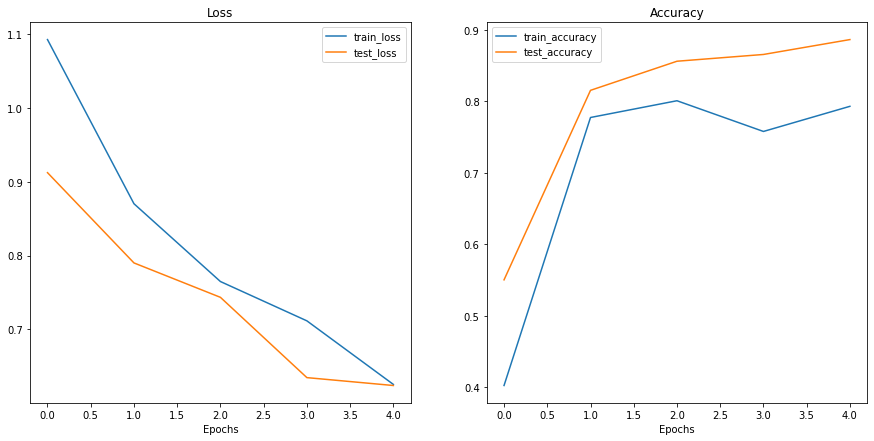

In [21]:
# Get the plot_loss_curves() function from helper_functions.py, download the file if we don't have it
try:
    from helper_functions import plot_loss_curves
except:
    print("[INFO] Couldn't find helper_functions.py, downloading...")
    with open("helper_functions.py", "wb") as f:
        import requests
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
        f.write(request.content)
    from helper_functions import plot_loss_curves

# Plot the loss curves of our model
plot_loss_curves(results)

Those are some excellent looking loss curves!

It looks like the loss for both datasets (train and test) is heading in the right direction.

The same with the accuracy values, trending upwards.

That goes to show the power of transfer learning. Using a pretrained model often leads to pretty good results with a small amount of data in less time.

## 6. Make predictions on images from the test set

It looks like our model performs well quantitatively but how about qualitatively?

Let's find out by making some predictions with our model on images from the test set (these aren't seen during training) and plotting them.

Visualize, visualize, visualize!

One thing we'll have to remember is that for our model to make predictions on an image, the image has to be in same format as the images our model was trained on.

In [22]:
from typing import List, Tuple

from PIL import Image

# 1. Take in a trained model, class names, image path, image size, a transform and target device
def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str, 
                        class_names: List[str],
                        image_size: Tuple[int, int] = (224, 224),
                        transform: torchvision.transforms = None,
                        device: torch.device=device):
    
    
    # 2. Open image
    img = Image.open(image_path)

    # 3. Create transformation for image (if one doesn't exist)
    if transform is not None:
        image_transform = transform
    else:
        image_transform = transforms.Compose([
            transforms.Resize(image_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225]),
        ])

    ### Predict on image ### 

    # 4. Make sure the model is on the target device
    model.to(device)

    # 5. Turn on model evaluation mode and inference mode
    model.eval()
    with torch.inference_mode():
      # 6. Transform and add an extra dimension to image (model requires samples in [batch_size, color_channels, height, width])
      transformed_image = image_transform(img).unsqueeze(dim=0)

      # 7. Make a prediction on image with an extra dimension and send it to the target device
      target_image_pred = model(transformed_image.to(device))

    # 8. Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

    # 9. Convert prediction probabilities -> prediction labels
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

    # 10. Plot image with predicted label and probability 
    plt.figure()
    plt.imshow(img)
    plt.title(f"Pred: {class_names[target_image_pred_label]} | Prob: {target_image_pred_probs.max():.3f}")
    plt.axis(False);

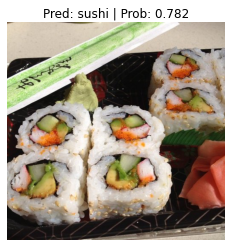

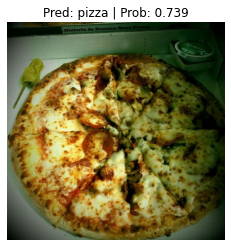

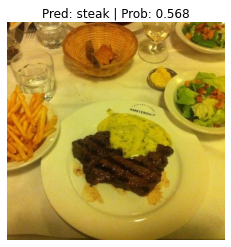

In [23]:
# Get a random list of image paths from test set
import random
num_images_to_plot = 3
test_image_path_list = list(Path(test_dir).glob("*/*.jpg")) # get list all image paths from test data 
test_image_path_sample = random.sample(population=test_image_path_list, # go through all of the test image paths
                                       k=num_images_to_plot) # randomly select 'k' image paths to pred and plot

# Make predictions on and plot the images
for image_path in test_image_path_sample:
    pred_and_plot_image(model=model, 
                        image_path=image_path,
                        class_names=class_names,
                        # transform=weights.transforms(), # optionally pass in a specified transform from our pretrained model weights
                        image_size=(224, 224))

### 6.1 Making predictions on a custom image

It looks like our model does well qualitatively on data from the test set.

But how about on our own custom image?

That's where the real fun of machine learning is!

Predicting on your own custom data, outisde of any training or test set.

To test our model on a custom image, let's import the old faithful `pizza-dad.jpeg` image (an image of my dad eating pizza).

We'll then pass it to the `pred_and_plot_image()` function we created above and see what happens.

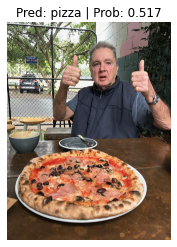

In [24]:
# Download custom image
import requests

# Setup custom image path
custom_image_path = data_path / "04-pizza-dad.jpeg"

# Download the image if it doesn't already exist
if not custom_image_path.is_file():
    with open(custom_image_path, "wb") as f:
        # When downloading from GitHub, need to use the "raw" file link
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
        print(f"Downloading {custom_image_path}...")
        f.write(request.content)
else:
    print(f"{custom_image_path} already exists, skipping download.")

# Predict on custom image
pred_and_plot_image(model=model,
                    image_path=custom_image_path,
                    class_names=class_names)

### Main takeaways

* Transfer learning often allows to you get good results with a relatively small amount of custom data.

* Knowing the power of transfer learning, it's a good idea to ask at the start of every problem, "does an existing well-performing model exist for my problem?"

* When using a pretrained model, it's important that your custom data be formatted/preprocessed in the same way that the original model was trained on, otherwise you may get degraded performance.

* The same goes for predicting on custom data, ensure your custom data is in the same format as the data your model was trained on.

* There are <a href = 'https://www.learnpytorch.io/06_pytorch_transfer_learning/#where-to-find-pretrained-models'>several different places to find pretrained models</a> from the PyTorch domain libraries, HuggingFace Hub and libraries such as timm (PyTorch Image Models).

#Excercise

### 1. Make predictions on the entire test dataset and plot a confusion matrix for the results of our model compared to the truth labels.

In [25]:
# Import required libraries/code
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt

from torch import nn
from torchvision import transforms, datasets

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine

In [26]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

##Get Data

In [27]:
import os
import requests
import zipfile

from pathlib import Path

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# If the image folder doesn't exist, download it and prepare it... 
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)
    
    # Download pizza, steak, sushi data
    with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        print("Downloading pizza, steak, sushi data...")
        f.write(request.content)

    # Unzip pizza, steak, sushi data
    with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
        print("Unzipping pizza, steak, sushi data...") 
        zip_ref.extractall(image_path)

    # Remove .zip file
    os.remove(data_path / "pizza_steak_sushi.zip")

# Setup Dirs
train_dir = image_path / "train"
test_dir = image_path / "test"

data/pizza_steak_sushi directory exists.


## Prepare data

In [28]:
# Create a transforms pipeline
simple_transform = transforms.Compose([
    transforms.Resize((224, 224)), # 1. Reshape all images to 224x224 (though some models may require different sizes)
    transforms.ToTensor(), # 2. Turn image values to between 0 & 1 
    transforms.Normalize(mean=[0.485, 0.456, 0.406], # 3. A mean of [0.485, 0.456, 0.406] (across each colour channel)
                         std=[0.229, 0.224, 0.225]) # 4. A standard deviation of [0.229, 0.224, 0.225] (across each colour channel),
])

In [29]:
# Create training and testing DataLoader's as well as get a list of class names
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=simple_transform, # resize, convert images to between 0 & 1 and normalize them
                                                                               batch_size=32) # set mini-batch size to 32

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7fddd01ca310>,
 ['pizza', 'steak', 'sushi'])

## Get and prepare a pretrained model

In [30]:
# Setup the model with pretrained weights and send it to the target device 
model_0 = torchvision.models.efficientnet_b0(pretrained=True).to(device)
#model_0 # uncomment to output (it's very long)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [31]:
# Freeze all base layers in the "features" section of the model (the feature extractor) by setting requires_grad=False
for param in model_0.features.parameters():
    param.requires_grad = False

In [32]:
# Set the manual seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Get the length of class_names (one output unit for each class)
output_shape = len(class_names)

# Recreate the classifier layer and seed it to the target device
model_0.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True), 
    torch.nn.Linear(in_features=1280, 
                    out_features=output_shape, # same number of output units as our number of classes
                    bias=True)).to(device)

## Train model

In [33]:
# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_0.parameters(), lr=0.001)

In [34]:
# Set the random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer
from timeit import default_timer as timer 
start_time = timer()

# Setup training and save the results
model_0_results = engine.train(model=model_0,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=5,
                       device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0894 | train_acc: 0.4492 | test_loss: 0.9214 | test_acc: 0.5085
Epoch: 2 | train_loss: 0.8697 | train_acc: 0.7734 | test_loss: 0.8036 | test_acc: 0.7434
Epoch: 3 | train_loss: 0.7769 | train_acc: 0.7734 | test_loss: 0.7404 | test_acc: 0.7737
Epoch: 4 | train_loss: 0.7244 | train_acc: 0.7422 | test_loss: 0.6488 | test_acc: 0.8864
Epoch: 5 | train_loss: 0.6426 | train_acc: 0.7812 | test_loss: 0.6254 | test_acc: 0.8968
[INFO] Total training time: 10.886 seconds


## Make predictions on the entire test dataset with the model

In [35]:
len(test_dataloader)

3

In [36]:
from tqdm.auto import tqdm

# Make predictions on the entire test dataset
test_preds = []
model_0.eval()
with torch.inference_mode():
  # Loop through the batches in the test dataloader
  for X, y in tqdm(test_dataloader):
    X, y = X.to(device), y.to(device)
    # Pass the data through the model
    test_logits = model_0(X)

    # Convert the pred logits to pred probs
    pred_probs = torch.softmax(test_logits, dim=1)

    # Convert the pred probs into pred labels
    pred_labels = torch.argmax(pred_probs, dim=1)

    # Add the pred labels to test preds list
    test_preds.append(pred_labels)

# Concatenate the test preds and put them on the CPU
test_preds = torch.cat(test_preds).cpu()
test_preds

  0%|          | 0/3 [00:00<?, ?it/s]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 2, 1, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0,
        2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2,
        2, 2, 2])

## Make a confusion matrix with the test preds and the truth labels

In [37]:
# Get the truth labels for test dataset
test_truth = torch.cat([y for X, y in test_dataloader])
test_truth

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2])

In [38]:
# See if torchmetrics exists, if not, install it
try:
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")
    assert int(mlxtend.__version__.split(".")[1]) >= 19, "mlxtend verison should be 0.19.0 or higher"
except:
    !pip install -q torchmetrics -U mlxtend # <- Note: If you're using Google Colab, this may require restarting the runtime
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")

     |████████████████████████████████| 529 kB 7.8 MB/s 
     |████████████████████████████████| 1.3 MB 57.2 MB/s 
mlxtend version: 0.21.0


In [39]:
# Import mlxtend upgraded version
import mlxtend 
print(mlxtend.__version__)
assert int(mlxtend.__version__.split(".")[1]) >= 19 # should be version 0.19.0 or higher

0.21.0


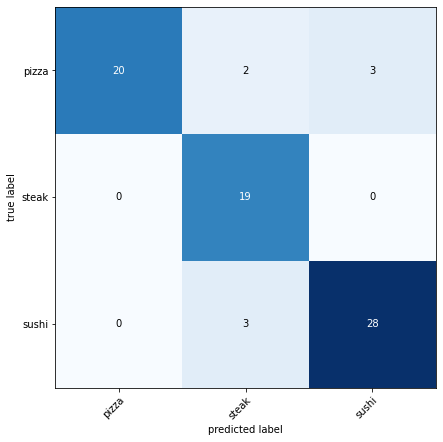

In [40]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

# Setup confusion matrix instance
confmat = ConfusionMatrix(num_classes=len(class_names))
confmat_tensor = confmat(preds=test_preds,
                         target=test_truth)

# Plot the confusion matrix
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(), # matplotlib likes working with NumPy
    class_names=class_names,
    figsize=(10, 7)
)


## 2. Get the "most wrong" of the predictions on the test dataset and plot the 5 "most wrong" images. You can do this by:

* Predicting across all of the test dataset, storing the labels and predicted probabilities.

* Sort the predictions by wrong prediction and then descending predicted probabilities, this will give you the wrong predictions with the highest prediction probabilities, in other words, the "most wrong".

* Plot the top 5 "most wrong" images, why do you think the model got these wrong?

Want to:

* Create a DataFrame with sample, label, prediction, pred prob

* Sort DataFrame by correct (does label == prediction)

* Sort DataFrame by pred prob (descending)

* Plot the top 5 "most wrong"

In [41]:
# Get all test data paths
from pathlib import Path
test_data_paths = list(Path(test_dir).glob("*/*.jpg"))
test_labels = [path.parent.stem for path in test_data_paths]

# Create a function to return a list of dictionaries with sample, label, prediction, pred prob
def pred_and_store(test_paths, model, transform, class_names, device):
  test_pred_list = []
  for path in tqdm(test_paths):
    # Create empty dict to store info for each sample
    pred_dict = {}

    # Get sample path
    pred_dict["image_path"] = path

    # Get class name
    class_name = path.parent.stem
    pred_dict["class_name"] = class_name

    # Get prediction and prediction probability
    from PIL import Image
    img = Image.open(path) # open image
    transformed_image = transform(img).unsqueeze(0) # transform image and add batch dimension
    model.eval()
    with torch.inference_mode():
      pred_logit = model(transformed_image.to(device))
      pred_prob = torch.softmax(pred_logit, dim=1)
      pred_label = torch.argmax(pred_prob, dim=1)
      pred_class = class_names[pred_label.cpu()]

      # Make sure things in the dictionary are back on the CPU 
      pred_dict["pred_prob"] = pred_prob.unsqueeze(0).max().cpu().item()
      pred_dict["pred_class"] = pred_class
  
    # Does the pred match the true label?
    pred_dict["correct"] = class_name == pred_class

    # print(pred_dict)
    # Add the dictionary to the list of preds
    test_pred_list.append(pred_dict)

  return test_pred_list

test_pred_dicts = pred_and_store(test_paths=test_data_paths,
                                 model=model_0,
                                 transform=simple_transform,
                                 class_names=class_names,
                                 device=device)

test_pred_dicts[:5]

  0%|          | 0/75 [00:00<?, ?it/s]

[{'image_path': PosixPath('data/pizza_steak_sushi/test/steak/3873283.jpg'),
  'class_name': 'steak',
  'pred_prob': 0.4080165922641754,
  'pred_class': 'steak',
  'correct': True},
 {'image_path': PosixPath('data/pizza_steak_sushi/test/steak/1285886.jpg'),
  'class_name': 'steak',
  'pred_prob': 0.4617844521999359,
  'pred_class': 'steak',
  'correct': True},
 {'image_path': PosixPath('data/pizza_steak_sushi/test/steak/894825.jpg'),
  'class_name': 'steak',
  'pred_prob': 0.8598989844322205,
  'pred_class': 'steak',
  'correct': True},
 {'image_path': PosixPath('data/pizza_steak_sushi/test/steak/3424937.jpg'),
  'class_name': 'steak',
  'pred_prob': 0.8426523208618164,
  'pred_class': 'steak',
  'correct': True},
 {'image_path': PosixPath('data/pizza_steak_sushi/test/steak/1302563.jpg'),
  'class_name': 'steak',
  'pred_prob': 0.8424509763717651,
  'pred_class': 'steak',
  'correct': True}]

In [42]:
# Turn the test_pred_dicts into a DataFrame
import pandas as pd
test_pred_df = pd.DataFrame(test_pred_dicts)
# Sort DataFrame by correct then by pred_prob 
top_5_most_wrong = test_pred_df.sort_values(by=["correct", "pred_prob"], ascending=[True, False]).head()
top_5_most_wrong

,image_path,class_name,pred_prob,pred_class,correct
35,data/pizza_steak_sushi/test/sushi/684266.jpg,sushi,0.547931,steak,False
54,data/pizza_steak_sushi/test/pizza/971934.jpg,pizza,0.454041,sushi,False
38,data/pizza_steak_sushi/test/sushi/1172255.jpg,sushi,0.448240,steak,False
70,data/pizza_steak_sushi/test/pizza/2508636.jpg,pizza,0.428751,sushi,False
68,data/pizza_steak_sushi/test/pizza/2871261.jpg,pizza,0.424841,steak,False


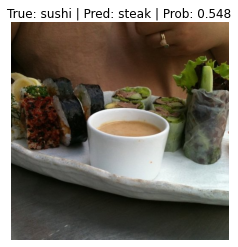

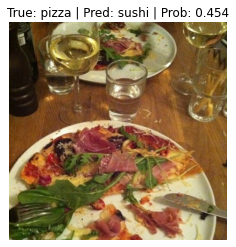

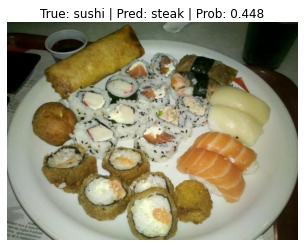

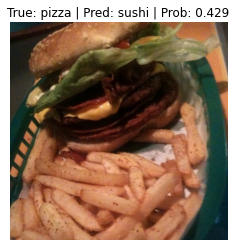

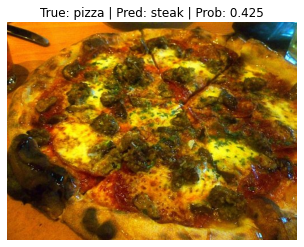

In [43]:
import torchvision
import matplotlib.pyplot as plt
# Plot the top 5 most wrong images
for row in top_5_most_wrong.iterrows():
  row = row[1]
  image_path = row[0]
  true_label = row[1]
  pred_prob = row[2]
  pred_class = row[3]
  # Plot the image and various details
  img = torchvision.io.read_image(str(image_path)) # get image as tensor
  plt.figure()
  plt.imshow(img.permute(1, 2, 0)) # matplotlib likes images in [height, width, color_channels]
  plt.title(f"True: {true_label} | Pred: {pred_class} | Prob: {pred_prob:.3f}")
  plt.axis(False);

## 3. Predict on your own image of pizza/steak/sushi - how does the model go? What happens if you predict on an image that isn't pizza/steak/sushi?

--2022-10-05 11:48:15--  https://images.unsplash.com/photo-1588315029754-2dd089d39a1a
Resolving images.unsplash.com (images.unsplash.com)... 151.101.22.208, 2a04:4e42:d::720
Connecting to images.unsplash.com (images.unsplash.com)|151.101.22.208|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4343742 (4.1M) [image/jpeg]
Saving to: ‘photo-1588315029754-2dd089d39a1a.1’

photo-1588315029754 100%[===================>]   4.14M  --.-KB/s    in 0.05s   

2022-10-05 11:48:15 (76.9 MB/s) - ‘photo-1588315029754-2dd089d39a1a.1’ saved [4343742/4343742]



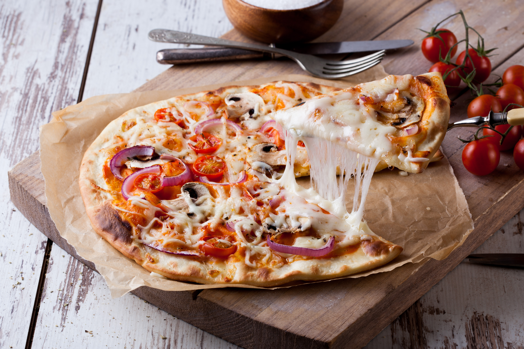

In [44]:
# Get an image of pizza/steak/sushi
!wget https://images.unsplash.com/photo-1588315029754-2dd089d39a1a 
!cp photo-1588315029754-2dd089d39a1a pizza.jpg

from PIL import Image

with Image.open("pizza.jpg") as img:
  # Reduce the image size and width by 10
  (width, height) = (img.width // 10, img.height // 10)
  img_resized = img.resize((width, height))

img_resized

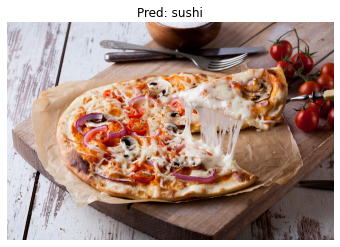

In [45]:
# Make a function to pred and plot images
def pred_and_plot(image_path, model, transform, class_names, device=device):
  # open image
  image = Image.open(image_path)

  # transform image
  transformed_image = transform(image)

  # pred on image
  model.eval()
  with torch.inference_mode():
    pred_logit = model(transformed_image.unsqueeze(0).to(device))
    pred_label = torch.argmax(torch.softmax(pred_logit, dim=1), dim=1)
  
  # plot image and pred
  plt.figure() 
  plt.imshow(image)
  plt.title(f"Pred: {class_names[pred_label]}")
  plt.axis(False);

pred_and_plot(image_path="pizza.jpg",
              model=model_0,
              transform=simple_transform,
              class_names=class_names)

--2022-10-05 11:49:23--  https://images.unsplash.com/photo-1546964124-0cce460f38ef
Resolving images.unsplash.com (images.unsplash.com)... 151.101.22.208, 2a04:4e42:d::720
Connecting to images.unsplash.com (images.unsplash.com)|151.101.22.208|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13559943 (13M) [image/jpeg]
Saving to: ‘photo-1546964124-0cce460f38ef’

photo-1546964124-0c 100%[===================>]  12.93M  --.-KB/s    in 0.1s    

2022-10-05 11:49:23 (103 MB/s) - ‘photo-1546964124-0cce460f38ef’ saved [13559943/13559943]



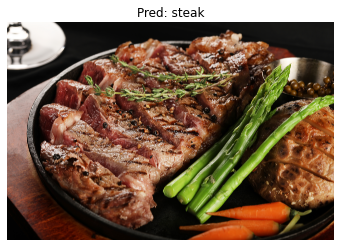

In [46]:
# Try again on a photo of steak from unsplash.com 
!wget https://images.unsplash.com/photo-1546964124-0cce460f38ef
!cp photo-1546964124-0cce460f38ef steak.jpg

pred_and_plot("steak.jpg",
              model=model_0,
              transform=simple_transform,
              class_names=class_names)

--2022-10-05 11:49:34--  https://images.unsplash.com/photo-1570913149827-d2ac84ab3f9a
Resolving images.unsplash.com (images.unsplash.com)... 151.101.22.208, 2a04:4e42:d::720
Connecting to images.unsplash.com (images.unsplash.com)|151.101.22.208|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6876691 (6.6M) [image/jpeg]
Saving to: ‘photo-1570913149827-d2ac84ab3f9a’

photo-1570913149827 100%[===================>]   6.56M  --.-KB/s    in 0.07s   

2022-10-05 11:49:34 (92.7 MB/s) - ‘photo-1570913149827-d2ac84ab3f9a’ saved [6876691/6876691]



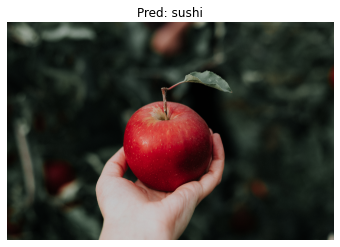

In [47]:
# Get an image of not pizza/steak/sushi
!wget https://images.unsplash.com/photo-1570913149827-d2ac84ab3f9a
!cp photo-1570913149827-d2ac84ab3f9a apple.jpg 

pred_and_plot(image_path="apple.jpg",
              model=model_0,
              transform=simple_transform,
              class_names=class_names)

## 4. Train the model from section 4 above for longer (10 epochs should do), what happens to the performance?

In [48]:
# Recreate a new model 
import torchvision 
from torch import nn
model_1 = torchvision.models.efficientnet_b0(pretrained=True).to(device)

# Freeze the base layers
for param in model_1.features.parameters():
  param.requires_grad = False

# Change the classification head
torch.manual_seed(42)
model_1.classifier = torch.nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1280, out_features=len(class_names), bias=True)
).to(device) 

# summary(model_1, 
#         input_size=[32, 3, 224, 224],
#         col_names=["input_size", "output_size", "trainable"])

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [49]:
# Set the random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer
from timeit import default_timer as timer 
start_time = timer()

# Create loss and optimizer 
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_1.parameters(), lr=0.001)

# Setup training and save the results
model_1_results = engine.train(model=model_1,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=10,
                       device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0894 | train_acc: 0.4492 | test_loss: 0.9214 | test_acc: 0.5085
Epoch: 2 | train_loss: 0.8697 | train_acc: 0.7734 | test_loss: 0.8036 | test_acc: 0.7434
Epoch: 3 | train_loss: 0.7769 | train_acc: 0.7734 | test_loss: 0.7404 | test_acc: 0.7737
Epoch: 4 | train_loss: 0.7244 | train_acc: 0.7422 | test_loss: 0.6488 | test_acc: 0.8864
Epoch: 5 | train_loss: 0.6426 | train_acc: 0.7812 | test_loss: 0.6254 | test_acc: 0.8968
Epoch: 6 | train_loss: 0.6027 | train_acc: 0.7695 | test_loss: 0.5583 | test_acc: 0.8968
Epoch: 7 | train_loss: 0.5406 | train_acc: 0.9297 | test_loss: 0.5296 | test_acc: 0.9176
Epoch: 8 | train_loss: 0.5487 | train_acc: 0.8125 | test_loss: 0.5294 | test_acc: 0.9176
Epoch: 9 | train_loss: 0.5701 | train_acc: 0.7969 | test_loss: 0.4963 | test_acc: 0.9176
Epoch: 10 | train_loss: 0.5207 | train_acc: 0.7969 | test_loss: 0.4215 | test_acc: 0.8655
[INFO] Total training time: 24.061 seconds


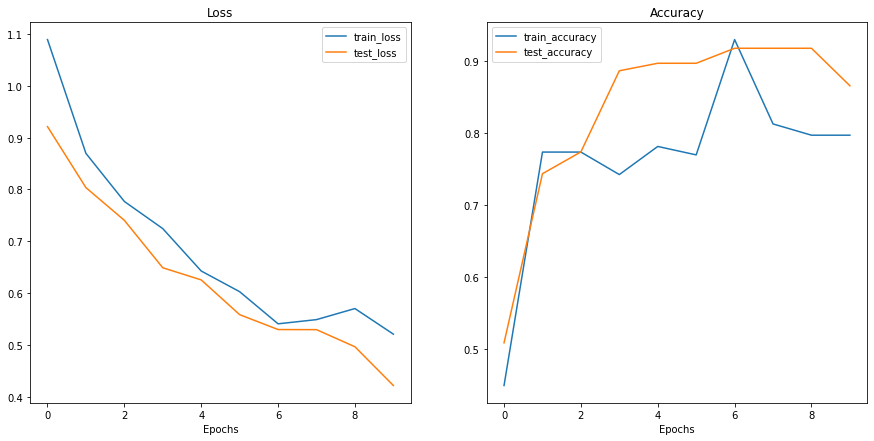

In [50]:
# Get the plot_loss_curves() function from helper_functions.py, download the file if we don't have it
try:
    from helper_functions import plot_loss_curves
except:
    print("[INFO] Couldn't find helper_functions.py, downloading...")
    with open("helper_functions.py", "wb") as f:
        import requests
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
        f.write(request.content)
    from helper_functions import plot_loss_curves

# Plot the loss curves of our model
plot_loss_curves(model_1_results)


If we train for longer, it looks like we get slightly lower loss and potentially higher accuracy but our model starts to look like it overfits if we train for too long.

Potentially data augmentation or a learning rate decay (lowering the learning rate over time) can help to prevent overfitting.

## 5. Train the model from section 4 above with more data, say 20% of the images from Food101 of Pizza, Steak and Sushi images.


### Get 20% data

In [51]:
import os
import requests
import zipfile

from pathlib import Path

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi_20_percent"
image_data_zip_path = "pizza_steak_sushi_20_percent.zip"

# If the image folder doesn't exist, download it and prepare it... 
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)
    
    # Download pizza, steak, sushi data
    with open(data_path / image_data_zip_path, "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip")
        print("Downloading pizza, steak, sushi data...")
        f.write(request.content)

    # Unzip pizza, steak, sushi data
    with zipfile.ZipFile(data_path / image_data_zip_path, "r") as zip_ref:
        print("Unzipping pizza, steak, sushi 20% data...") 
        zip_ref.extractall(image_path)

    # Remove .zip file
    os.remove(data_path / image_data_zip_path)

# Setup Dirs
train_dir_20_percent = image_path / "train"
test_dir_20_percent = image_path / "test"

train_dir_20_percent, test_dir_20_percent

Did not find data/pizza_steak_sushi_20_percent directory, creating one...
Unzipping pizza, steak, sushi 20% data...


(PosixPath('data/pizza_steak_sushi_20_percent/train'),
 PosixPath('data/pizza_steak_sushi_20_percent/test'))

### Create DataLoaders

In [52]:
# Create a transforms pipeline
simple_transform = transforms.Compose([
    transforms.Resize((224, 224)), # 1. Reshape all images to 224x224 (though some models may require different sizes)
    transforms.ToTensor(), # 2. Turn image values to between 0 & 1 
    transforms.Normalize(mean=[0.485, 0.456, 0.406], # 3. A mean of [0.485, 0.456, 0.406] (across each colour channel)
                         std=[0.229, 0.224, 0.225]) # 4. A standard deviation of [0.229, 0.224, 0.225] (across each colour channel),
])

In [53]:
# Create training and testing DataLoader's as well as get a list of class names
train_dataloader_20_percent, test_dataloader_20_percent, class_names = data_setup.create_dataloaders(train_dir=train_dir_20_percent,
                                                                                                     test_dir=test_dir_20_percent,
                                                                                                     transform=simple_transform, # resize, convert images to between 0 & 1 and normalize them
                                                                                                     batch_size=32) # set mini-batch size to 32

train_dataloader_20_percent, test_dataloader_20_percent, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7fdd0840ecd0>,
 ['pizza', 'steak', 'sushi'])

In [54]:
len(train_dataloader_20_percent), len(test_dataloader_20_percent)

(15, 5)

### Get a pretrained model

In [55]:
# Create a new model for 20 percent of the data
model_2 = torchvision.models.efficientnet_b0(pretrained=True).to(device)

# Freeze all the base layers
for param in model_2.features.parameters():
  param.requires_grad = False

# Change the classifier head
torch.manual_seed(42)
model_2.classifier = nn.Sequential(
  nn.Dropout(p=0.2, inplace=True),
  nn.Linear(in_features=1280, out_features=3, bias=True)
).to(device)

### Train a model with 20% of the data

In [56]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_2.parameters(), lr=0.001)

# Set the random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer
from timeit import default_timer as timer 
start_time = timer()

# Setup training and save the results
model_2_results = engine.train(model=model_2,
                              train_dataloader=train_dataloader_20_percent,
                              test_dataloader=test_dataloader_20_percent,
                              optimizer=optimizer,
                              loss_fn=loss_fn,
                              epochs=5,
                              device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9753 | train_acc: 0.5625 | test_loss: 0.6485 | test_acc: 0.8886
Epoch: 2 | train_loss: 0.7084 | train_acc: 0.8187 | test_loss: 0.5306 | test_acc: 0.9006
Epoch: 3 | train_loss: 0.5867 | train_acc: 0.8292 | test_loss: 0.4531 | test_acc: 0.8881
Epoch: 4 | train_loss: 0.4557 | train_acc: 0.8875 | test_loss: 0.4102 | test_acc: 0.9034
Epoch: 5 | train_loss: 0.4524 | train_acc: 0.8896 | test_loss: 0.3795 | test_acc: 0.8852
[INFO] Total training time: 30.187 seconds


In [57]:
# Check results with 10% of data for 5 epochs
max(model_0_results["test_acc"]), min(model_0_results["test_loss"])

(0.8967803030303031, 0.6254069209098816)

In [58]:
# Check results with 20% of data for 5 epochs 
max(model_2_results["test_acc"]), min(model_2_results["test_loss"])

(0.903409090909091, 0.37946630716323854)

### 6. Try a different model from torchvision.models on the Pizza, Steak, Sushi data, how does this model perform?

* You'll have to change the size of the classifier layer to suit our problem.

* You may want to try an EfficientNet with a higher number than our `B0`, perhaps `torchvision.models.efficientnet_b2()`?

In [59]:
# Create a transform to transform the data
from torchvision import transforms, models
effnet_b2_transform = transforms.Compose([
  transforms.Resize((288, 288)), # effnet_b2 takes images of size 288, 288 - https://github.com/pytorch/vision/blob/d2bfd639e46e1c5dc3c177f889dc7750c8d137c7/references/classification/train.py#L92-L93
  transforms.ToTensor(),
  transforms.Normalize(mean=[0.485, 0.456, 0.406],
                       std=[0.229, 0.224, 0.225])
])

In [60]:
# Use 10% data sample for effnet_b2 to compare to model_0_results
train_dir, test_dir


(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

In [61]:
# Import the data
train_dataloader_effnet_b2, test_dataloader_effnet_b2, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                                   test_dir=test_dir,
                                                                                                   transform=effnet_b2_transform,
                                                                                                   batch_size=32)


In [62]:
# Create a effnet_b2 new model - https://pytorch.org/vision/stable/generated/torchvision.models.efficientnet_b2.html#torchvision.models.efficientnet_b2
model_3 = torchvision.models.efficientnet_b2(pretrained=True).to(device)

# Freeze the base layers
for param in model_3.parameters():
  param.requires_grad = False

# Change the classifier head (to suit our problem)
torch.manual_seed(42)
model_3.classifier = nn.Sequential(
    nn.Dropout(p=0.3, inplace=True),
    nn.Linear(in_features=1408, out_features=len(class_names), bias=True)
).to(device)

# Get a summary of the new model
# summary(model_3,
#         input_size=[32, 3, 288, 288],
#         col_names=["input_size", "output_size", "trainable"])

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=EfficientNet_B2_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-bcdf34b7.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b2_rwightman-bcdf34b7.pth


  0%|          | 0.00/35.2M [00:00<?, ?B/s]

In [63]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_3.parameters(), lr=0.001)

# Set the random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer
from timeit import default_timer as timer 
start_time = timer()

# Setup training and save the results
model_3_results = engine.train(model=model_3,
                              train_dataloader=train_dataloader_effnet_b2,
                              test_dataloader=test_dataloader_effnet_b2,
                              optimizer=optimizer,
                              loss_fn=loss_fn,
                              epochs=5,
                              device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1116 | train_acc: 0.3281 | test_loss: 0.9128 | test_acc: 0.7027
Epoch: 2 | train_loss: 0.8984 | train_acc: 0.6680 | test_loss: 0.8666 | test_acc: 0.8248
Epoch: 3 | train_loss: 0.8054 | train_acc: 0.7930 | test_loss: 0.7903 | test_acc: 0.8456
Epoch: 4 | train_loss: 0.7401 | train_acc: 0.7656 | test_loss: 0.6711 | test_acc: 0.9280
Epoch: 5 | train_loss: 0.6473 | train_acc: 0.8047 | test_loss: 0.6556 | test_acc: 0.8769
[INFO] Total training time: 15.109 seconds


In [64]:
# Check effnet_b0 results with 10% of data for 5 epochs
max(model_0_results["test_acc"]), min(model_0_results["test_loss"])

(0.8967803030303031, 0.6254069209098816)

In [65]:
# Check effnet_b0 results with 10% of data for 10 epochs (double training time)
max(model_1_results["test_acc"]), min(model_1_results["test_loss"])

(0.9176136363636364, 0.42152061065038043)

In [66]:
# Check effnet_b0 results with 20% of data for 5 epochs (double data)
max(model_2_results["test_acc"]), min(model_2_results["test_loss"])

(0.903409090909091, 0.37946630716323854)

In [67]:
# Check effnet_b2 results with 10% of data for 5 epochs (double model parameters)
max(model_3_results["test_acc"]), min(model_3_results["test_loss"])


(0.9280303030303031, 0.6556313037872314)